# Multi-task logistic regression for individual survival prediction
Multi-task logistic regression (MTLR) is a machine learning algorithm for survival prediction. It overcomes many of the limitations of existing methods (e.g. the Cox proportional hazard model) by directly modelling the survival curve of each individual, allowing for more accurate individualised survival prediction. This notebook contains a PyTorch implementation of MTLR, together with experiments on simulated and real data. In my [blog post](https://mkazmierski.me/ml/2020/12/08/mtlr_survival.html), you can find derivation and theoretical background. There's also a Google Colab version of this notebook, available [here](https://colab.research.google.com/drive/1CkIEzctAE8_WPsXQdt2xPkY1kwbN3BSX?usp=sharing).

# More on MTLR
MTLR is an algorithm that is used for survival analysis this is the branch of statistics that deals with predicting the time until an event occurs. 

It will directly model the survival curve of each individual in the dataset, providing personalized predictions for each individual.

In [1]:
#validating imports
import numpy
import sklearn

print("numpy version: ", numpy.__version__)
print("sklearn version: ", sklearn.__version__)

numpy version:  1.26.4
sklearn version:  1.5.1


In [2]:
%matplotlib inline 
from math import sqrt, ceil
from collections import defaultdict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn

from torch.utils.data import DataLoader, TensorDataset
from torch.optim import Adam
from sklearn.model_selection import KFold, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import brier_score_loss, roc_auc_score

In [3]:
from fuzzywuzzy import process

/Users/preciousajilore/Documents/GitHub/torchmtlr/survivalenv/lib/python3.12/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [4]:

from lifelines import CoxPHFitter, KaplanMeierFitter
from lifelines.utils import concordance_index
from tqdm import tqdm, trange

from torchmtlr import (MTLR, DeepMTLR, mtlr_neg_log_likelihood,
                       mtlr_survival, mtlr_survival_at_times,
                       mtlr_risk)
from torchmtlr.utils import (make_time_bins, encode_survival,
                             make_optimizer)

torch.manual_seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

sns.set(context="poster", style="white")
plt.rcParams["figure.figsize"] = (10, 7)

## MTLR implementation
Quick remark on notation: subscripts (e.g. $x_k$) denote indexing over timepoints, while superscripts (like $y^{(j)}$) indicate indexing over datapoints.

First comes the MTLR likelihood implementation. You can find the basic likelihood definition in [the original publication](https://papers.nips.cc/paper/4210-learning-patient-specific-cancer-survival-distributions-as-a-sequence-of-dependent-regressors). Briefly, the approach is to discretise the time axis into $K$ bins and fit a logistic regression model to predict the probability of event in each bin.

<center><img src="time_bins.png" width="600"> </center>

*[Image source](https://era.library.ualberta.ca/items/3deb4dd9-788d-4c61-94a5-d3ee6645f74f).*


The probability of event time $T$ falling in the bin $[\tau_{i-1}, \tau_i)$ given covariates $\mathbf{x}$ is modelled as:

$$
P(\tau_{i-1} \le T < \tau_i \mid \mathbf{x}, \boldsymbol{\theta}) = \frac{\exp(\sum_{k=i}^{K-1}\boldsymbol{\theta}_k^T \mathbf{x} + b_k)}{Z(\mathbf{x}, \boldsymbol{\Theta})},
$$

where $\boldsymbol{\theta}_k, b_k$ are the model parameters and $Z = \sum_{i=1}^K \exp(\sum_{k=i}^{K-1}\boldsymbol{\theta}_k^T\mathbf{x} + b_k)$ is the normalizing constant.

Here, we use the reformulation as softmax classifier (first derived [here](https://era.library.ualberta.ca/items/3deb4dd9-788d-4c61-94a5-d3ee6645f74f)), allowing for more efficient computation. It essentially boils down to adding additional 'catch-all' time interval $[t_K, \infty)$ and slightly changing the target encoding, which lets us treat the problem as multi-class classification. Each uncensored instance is now assigned a single *class label*, which is represented as one-hot encoded binary vector. For instances censored at time $t_c$, we know that their true class label lies between $c_c$ and $c_K$, which is encoded as a binary vector with 1s at all indices $c-1 \le i \le K-1$. In this case, the 1s indicate the timepoints over which to marginalise. For example, if the time axis is split into 5 bins, an instance experiencing event in bin 3 (0-indexed) is encoded as `[0, 0, 0, 1, 0]`, and instance censored in bin 2 as `[0, 0, 1, 1, 1]`.

The log-likelihood for uncensored instances is similar to the standard softmax log-likelihood:

$$
L(\boldsymbol{\Theta}, \mathbf{x}, \mathbf{y}) = \sum_{k=i}^{K-1}(\boldsymbol{\theta}_k^T\mathbf{x} + b_k) - \log(Z(\mathbf{x}, \boldsymbol{\Theta})),
$$

where $i$ is the index of non-zero entry in $\mathbf{y}$.

For censored instances, we need to sum (marginalize) over all possible class probabilities:

$$
L(\boldsymbol{\Theta}, \mathbf{x}, \mathbf{y}) = \log(\sum_i \exp(\sum_{k=i}^{K-1}\boldsymbol{\theta}_k^T\mathbf{x} + b_k) - \log(Z(\mathbf{x}, \boldsymbol{\Theta})),
$$

where the sum is over all non-zero entries in $\mathbf{y}$. Here, the summation is over all timepoints later than the censoring time $T_c$.

The full log-likelihood for a dataset $D =
\{T^{(j)}, \delta^{(j)}, \mathbf{x}^{(j)}\}_{j=1}^{N}$ with $N$ instances, $N_c$ of which are censored, is 

$$
L(\boldsymbol{\Theta}, D) =
\sum_{j=1}^{N-N_c}\sum_{k=1}^{K-1}(\boldsymbol{\theta}_k^T\mathbf{x}^{(j)} + b_k)\mathbf{y}_k^{(j)} + 
\sum_{j=N_c}^{N}\log(\sum_{t_k > T_c^{(j)}} \exp(\sum_{k=1}^{K-1}\boldsymbol{\theta}_k^T\mathbf{x}^{(j)} + b_k)
- \sum_{j=1}^{N}\log(Z(\mathbf{x}^{(j)}, \boldsymbol{\Theta})) + \frac{C_1}{2}\sum_{k=1}^{K-1}\Vert\boldsymbol{\theta}_k\Vert^2.
$$

$C_1$ is a hyperparameter determining the strength of $\ell_2$ regularization, which also controls the smoothness of predicted survival curves.

In [5]:
def normalize(data, mean=None, std=None, skip_cols=[]):
    """Normalizes the columns of Pandas DataFrame to zero mean and unit
    standard deviation. Makes sure that all the features contribute equally to the model training"""
    if mean is None:
        mean = data.mean(axis=0)
    if std is None:
        std = data.std(axis=0)
    if skip_cols is not None:
        mean[skip_cols] = 0
        std[skip_cols] = 1
    return (data - mean) / std, mean, std


def reset_parameters(model):
    """Resets the parameters of a PyTorch module and its children."""
    for m in model.modules():
        try:
            m.reset_parameters()
        except AttributeError:
            continue
    return model


# training functions
def train_mtlr(model, data_train, time_bins,
               num_epochs=1000, lr=.01, weight_decay=0.,
               c1=1., batch_size=None,
               verbose=True, device="cpu"):
    """Trains the MTLR model using minibatch gradient descent.
    
    Parameters
    ----------
    model : torch.nn.Module
        MTLR model to train.
    data_train : pd.DataFrame
        The training dataset. Must contain a `time` column with the
        event time for each sample and an `event` column containing
        the event indicator.
    num_epochs : int
        Number of training epochs.
    lr : float
        The learning rate.
    weight_decay : float
        Weight decay strength for all parameters *except* the MTLR
        weights. Only used for Deep MTLR training.
    c1 : float
        L2 regularization (weight decay) strenght for MTLR parameters.
    batch_size : int
        The batch size.
    verbose : bool
        Whether to display training progress.
    device : str
        Device name or ID to use for training.
        
    Returns
    -------
    torch.nn.Module
        The trained model.
    """
    x = torch.tensor(data_train.drop(["time", "event"], axis=1).values, dtype=torch.float)
    y = encode_survival(data_train["time"].values, data_train["event"].values, time_bins)
    optimizer = make_optimizer(Adam, model, lr=lr, weight_decay=weight_decay) #optimizer that updates the parameters/weights of the model
    reset_parameters(model)
    model = model.to(device)
    model.train()
    train_loader = DataLoader(TensorDataset(x, y), batch_size=batch_size, shuffle=True)#DataLoader is used to load the data into batches
    
    pbar =  trange(num_epochs, disable=not verbose)
    for i in pbar:
        for xi, yi in train_loader:
            xi, yi = xi.to(device), yi.to(device)
            y_pred = model(xi)
            loss = mtlr_neg_log_likelihood(y_pred, yi, model, c1=c1, average=True)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        print(f"[epoch {i+1}/{num_epochs}] loss={loss.item():.4f}")  
          
        pbar.set_description(f"[epoch {i+1: 4}/{num_epochs}]")
        pbar.set_postfix_str(f"loss = {loss.item():.4f}")
    model.eval()
    

    return model


def train_mtlr_cv(model, data_train, time_bins, cv=3, c1_vals=None, verbose=True, device="cpu", **kwargs):
    """Trains the MTLR model using minibatch gradient descent, 
    determining the optimal L2 regularization strength with K-fold 
    cross-validation. Basically also trains and evaluates the model using different values of c1
    
    Parameters
    ----------
    model : torch.nn.Module
        MTLR model to train.
    data_train : pd.DataFrame
        The training dataset. Must contain a `time` column with the
        event time for each sample and an `event` column containing
        the event indicator.
    cv : int
        The number of cross-validation splits to use.
    c1_vals : float, optional
        L2 regularization (weight decay) values to test. If None (default),
        search over `np.logspace(-2, 3, 6)`.
    verbose : bool
        Whether to display training progress.
    device : str
        Device name or ID to use for training.
    kwargs
        Additional keyword arguments passed to `train_mtlr`.

    Returns
    -------
    torch.nn.Module
        The trained model.
    """
    if c1_vals is None:
        c1_vals = np.logspace(-2, 3, 6)
        
    kfold = KFold(n_splits=cv)
    nll_vals = defaultdict(list)
    for c1 in c1_vals:
        pbar = tqdm(kfold.split(data_train),
                    total=cv,
                    disable=not verbose,
                    desc=f"testing c1 = {c1:9}")
        for train_idx, val_idx in pbar:
            train_fold, val_fold = data_train.iloc[train_idx], data_train.iloc[val_idx]
            time_val, event_val = data_train.iloc[val_idx]["time"].values, data_train.iloc[val_idx]["event"].values
            x_val = torch.tensor(val_fold.drop(["time", "event"], axis=1).values,
                                 dtype=torch.float, device=device)
            y_val = encode_survival(time_val, event_val, time_bins).to(device)
            model = train_mtlr(model, train_fold, time_bins, c1=c1, device=device, verbose=False, **kwargs)
            with torch.no_grad():
                val_nll = mtlr_neg_log_likelihood(model(x_val), y_val, model, c1=c1)
                nll_vals[c1].append(val_nll.item())
            pbar.set_postfix_str(f"val nll = {val_nll.item():.2f}")
    
    # Choose regularization parameter with the lowest negative log-likelihood
    best_c1 = min(nll_vals, key=lambda k: sum(nll_vals[k]) / cv)
    
    if verbose:
        print(f"training with c1 = {best_c1}")
    
    model = train_mtlr(model, data_train, time_bins, c1=best_c1, device=device, verbose=verbose, **kwargs)
    return model

# Steps?

1) based on the columns in data_cleaned extract the features (which are classified as before surgery) from featurecategories 
2) and then use the data that corresponds to the features and split the data into training and testing sets
3) then use the training set to train a model and then use the test set to test the model
4) then evaluate the model using the test set

The dataset 

In [6]:
#Load CSV files

#Patient data
df = pd.read_csv('/Users/preciousajilore/Documents/GitHub/torchmtlr/data/cleanedfirstdraft.csv')

#Feature categories
feature_categories = pd.read_csv('/Users/preciousajilore/Documents/GitHub/torchmtlr/data/featurecatergories.csv') 

#Feature dictionary
feature_dict = pd.read_csv('/Users/preciousajilore/Documents/GitHub/torchmtlr/data/featuredictionary.csv')

In [7]:
#Just checking if the data is loaded
print(df.head())

  DOB (yyyy-mm-dd) Date of Surgery  monthsurg  Age  stxlocation  distal  \
0       1957-08-30      2021-01-11         43   63            2       0   
1       1983-05-07      2021-01-11         43   37            1       0   
2       1951-03-17      2021-01-15         43   69            1       0   
3       1970-10-11      2021-01-18         42   50            1       0   
4       1972-07-12      2021-01-25         42   48            1       0   

   penile  stxetiology  Stxlength  strictures  ...  PVD  Donor site  UTI post  \
0       0            3        2.0           1  ...    0           0         0   
1       0            0        4.0           1  ...    0           0         0   
2       0            5        4.5           1  ...    0           0         0   
3       0            0        4.0           1  ...    0           0         0   
4       0            0        4.0           1  ...    0           0         0   

   UTI recurring  LUTS  Persisting LUTS  Incontinence  Strictu

In [8]:
#Drop Empty Columns
df_cleaned = df.dropna(axis=1, how="all")
#Print the shape of df_cleaned
print(df_cleaned.head())
 

  DOB (yyyy-mm-dd) Date of Surgery  monthsurg  Age  stxlocation  distal  \
0       1957-08-30      2021-01-11         43   63            2       0   
1       1983-05-07      2021-01-11         43   37            1       0   
2       1951-03-17      2021-01-15         43   69            1       0   
3       1970-10-11      2021-01-18         42   50            1       0   
4       1972-07-12      2021-01-25         42   48            1       0   

   penile  stxetiology  Stxlength  strictures  ...  PVD  Donor site  UTI post  \
0       0            3        2.0           1  ...    0           0         0   
1       0            0        4.0           1  ...    0           0         0   
2       0            5        4.5           1  ...    0           0         0   
3       0            0        4.0           1  ...    0           0         0   
4       0            0        4.0           1  ...    0           0         0   

   UTI recurring  LUTS  Persisting LUTS  Incontinence  Strictu

In [10]:
import re

In [11]:
#Create a mapping of the abbreviations to the full names
feature_map = dict(zip(feature_dict['full name'], feature_dict['abbreviated name']))

# Print the mapping
print(feature_map)

# Extract the column corresponding to "features before surgery"

# Assuming the exact match or a partial match approach based on your column names
before_surgery_column = [col for col in feature_categories.columns if "before the surgery" in col.lower()]
if before_surgery_column:
    before_surgery_features = feature_categories[before_surgery_column[0]].dropna().tolist()
else:
    raise ValueError("Column related to 'features before surgery' not found.")





{'months since surgery': 'monthsurg', 'age': 'age', 'StxLocation LEGEND: 0=penile, 1=bulbar, 2= membranous/posterior, 3=panurethral, 4= penobulbar, 5= bulbomembranous, 6 = pars fixa': 'stxlocation', 'Distal Bulbar Involvement (0=No, 1=Yes)': 'distal', 'Penile Involvement (0=No, 1=Yes)': 'penile', 'StxEtiology(0=idio, 1=trauma, 2=bxo/ls, 3= radiation (EBRT/BT), 4=hypospadias, 5=iatrogenic, 6=inflammatory/infectious': 'stxetiology', 'Stx Length (cm) based on urethrogram/OR note , the biggest': 'stxlength', 'Number of Strictures': '#strictures', "Preop Comorbidities (use Charlson's comorbidity scale, see Sheet 3)": 'charlsons', 'Cormorbidity? No = 0; > or = 1 = 1': 'cormorbidity', 'Diabetes No = 0; > or = 1 = 1': 'diabetes', 'COPD (yes/no)': 'copd ', 'Smoker (yes 1 /no 0 )': 'smoker', 'BMI>35, 0=no, 1=yes': 'BMI35+', 'If > 35, what was it?)': 'BMI exact', 'Previous procedure: 1 = DVIU and/or dilations': 'prevprocedure', '# Previous Procedures (Dilatation/DVIU)': '#prevprocedures', 'Prior 

In [12]:
print ("original", before_surgery_features[0])
print("match", list(feature_map.keys())[2])

if before_surgery_features[0] == list(feature_map.keys())[2]:
    print("match")
else:
    print("no match")

original StxLocation LEGEND: 0=penile, 1=bulbar, 2= membranous/posterior, 3=panurethral, 4= penobulbar, 5= bulbomembranous, 6 = pars fixa
match StxLocation LEGEND: 0=penile, 1=bulbar, 2= membranous/posterior, 3=panurethral, 4= penobulbar, 5= bulbomembranous, 6 = pars fixa
match


In [13]:
def find_match(feature, feature_map):
    #Try to find an exact match
    if feature in feature_map:
        return feature_map[feature]
    
    #Try to find a partial match 
    for key in feature_map.keys():
        if str(feature).lower().strip() in str(key).lower().strip():
            return feature_map[key] 
        
    #Return original key is no match is found    
    return feature

before_abbrv = [find_match(feature, feature_map) for feature in before_surgery_features]

print(before_abbrv)


['stxlocation', 'distal', 'penile', 'stxetiology', 'stxlength', '#strictures', 'charlsons', 'cormorbidity', 'Diabetes (yes 1 /no 0 )', 'copd ', 'smoker', 'BMI35+', 'prevprocedure', 'open procedure? 1 = prev open procedure/urethroplasty', 'PrevProced (Dilat/DVIU = 1, no = 0)', '#prevprocedures', 'cysto', 'open']


In [14]:
# Debugging step
for feature in before_surgery_features:
    print(f"Original: {feature}")
    print(f"Matched: {find_match(feature, feature_map)}")


Original: StxLocation LEGEND: 0=penile, 1=bulbar, 2= membranous/posterior, 3=panurethral, 4= penobulbar, 5= bulbomembranous, 6 = pars fixa
Matched: stxlocation
Original: Distal Bulbar Involvement (0=No, 1=Yes)
Matched: distal
Original: Penile Involvement (0=No, 1=Yes)
Matched: penile
Original: StxEtiology(0=idio, 1=trauma, 2=bxo/ls, 3= radiation (EBRT/BT), 4=hypospadias, 5=iatrogenic, 6=inflammatory/infectious
Matched: stxetiology
Original: Stx Length (cm) based on urethrogram/OR note , the biggest
Matched: stxlength
Original: Number of Strictures
Matched: #strictures
Original: Preop Comorbidities (use Charlson's comorbidity scale, see Sheet 3)
Matched: charlsons
Original: Cormorbidity? No = 0; > or = 1 = 1
Matched: cormorbidity
Original: Diabetes (yes 1 /no 0 )
Matched: Diabetes (yes 1 /no 0 )
Original: COPD (yes/no)
Matched: copd 
Original: Smoker (yes 1 /no 0 )
Matched: smoker
Original: BMI>35, 0=no, 1=yes
Matched: BMI35+
Original: Previous procedure: 1 = DVIU and/or dilations
Match

In [15]:
#Replace the full names of feature names with their abbreviations
#before_abbrv = [feature_map.get(feature, feature) for feature in before_surgery_features]

#Print the abbreviated feature names
print(before_abbrv)

['stxlocation', 'distal', 'penile', 'stxetiology', 'stxlength', '#strictures', 'charlsons', 'cormorbidity', 'Diabetes (yes 1 /no 0 )', 'copd ', 'smoker', 'BMI35+', 'prevprocedure', 'open procedure? 1 = prev open procedure/urethroplasty', 'PrevProced (Dilat/DVIU = 1, no = 0)', '#prevprocedures', 'cysto', 'open']


In [16]:


#Replace the full names of feature names with their abbreviations
before_abbrv = [feature_map.get(feature, feature) for feature in before_surgery_features]

#Print the abbreviated feature names
print(before_abbrv)
#Get column names 
column_names = df.columns

#Match them with the features in before_surgery_features
chosen_features=[]

for feature in before_abbrv:
    #print("Feature", feature)
    match, score = process.extractOne(feature, column_names)
    if score > 80:
        #print("This:", match)
        chosen_features.append(match)   

#Add "datetofailure" and "failure" 
# Note these correspond as the "time to event" and "event"
chosen_features += ["datetofailurefu", "failure"]

#Print chosen features
for line in chosen_features:
    print(line)
#print(chosen_features)


['stxlocation', 'distal', 'penile', 'stxetiology', 'stxlength', '#strictures', 'charlsons', 'cormorbidity', 'Diabetes (yes 1 /no 0 )', 'copd ', 'smoker', 'BMI35+', 'prevprocedure', 'open procedure? 1 = prev open procedure/urethroplasty', 'PrevProced (Dilat/DVIU = 1, no = 0)', '#prevprocedures', 'cysto', 'open']
stxlocation
distal
penile
stxetiology
Stxlength
strictures
charlsons
Cormorbidity
Diabetes
COPD
Smoker
BMI35+
prevprocedure
#prevprocedures
cysto
open
datetofailurefu
failure


In [17]:
#Filter the data based on the chosen features
df_filtered = df[chosen_features].drop(columns=['strictures'])

#Verify the filtered data\
print(df_filtered.head())

   stxlocation  distal  penile  stxetiology  Stxlength  charlsons  \
0            2       0       0            3        2.0          2   
1            1       0       0            0        4.0          0   
2            1       0       0            5        4.5          4   
3            1       0       0            0        4.0          0   
4            1       0       0            0        4.0          0   

   Cormorbidity  Diabetes  COPD  Smoker  BMI35+  prevprocedure  \
0             1         0     0       1       1              1   
1             0         0     0       0       0              1   
2             1         1     0       0       0              1   
3             0         0     0       1       0              1   
4             0         0     0       0       0              1   

   #prevprocedures  cysto  open  datetofailurefu  failure  
0                2      1     0              6.0        0  
1                3      2     0              5.0        1  
2       

In [18]:
print(df_filtered.isnull().sum())

stxlocation        0
distal             0
penile             0
stxetiology        0
Stxlength          0
charlsons          0
Cormorbidity       0
Diabetes           0
COPD               0
Smoker             0
BMI35+             0
prevprocedure      0
#prevprocedures    0
cysto              0
open               0
datetofailurefu    0
failure            0
dtype: int64


In [19]:
print(f"Data Set Size: {df_filtered.shape}")

Data Set Size: (121, 17)


In [20]:
#Split the data into training and testing sets
df_train, df_test = train_test_split(df_filtered, test_size=0.5, random_state=42)

#Verify the split 
print(f"Training Set Size: {df_train.shape}")
print(f"Testing Set Size: {df_test.shape}")


Training Set Size: (60, 17)
Testing Set Size: (61, 17)


In [21]:
#Rename the datetofailurefu" and "failure" columns
df_train = df_train.rename(columns={'datetofailurefu': 'time', 'failure': 'event'})
df_test = df_test.rename(columns={'datetofailurefu': 'time', 'failure': 'event'})

In [22]:
#Identify the columns with string object data types
string_cols = df_train.select_dtypes(include=['object']).columns

print(string_cols)

Index([], dtype='object')


In [23]:
print(df_train.dtypes)


stxlocation          int64
distal               int64
penile               int64
stxetiology          int64
Stxlength          float64
charlsons            int64
Cormorbidity         int64
Diabetes             int64
COPD                 int64
Smoker               int64
BMI35+               int64
prevprocedure        int64
#prevprocedures      int64
cysto                int64
open                 int64
time               float64
event                int64
dtype: object


In [24]:
print(df_train.isnull().sum())

stxlocation        0
distal             0
penile             0
stxetiology        0
Stxlength          0
charlsons          0
Cormorbidity       0
Diabetes           0
COPD               0
Smoker             0
BMI35+             0
prevprocedure      0
#prevprocedures    0
cysto              0
open               0
time               0
event              0
dtype: int64


In [25]:
print(df_train.describe())

       stxlocation     distal     penile  stxetiology  Stxlength  charlsons  \
count    60.000000  60.000000  60.000000    60.000000  60.000000  60.000000   
mean      1.400000   0.133333   0.433333     1.866667   4.841667   0.966667   
std       1.463685   0.342803   0.499717     1.826979   3.206841   1.275143   
min       0.000000   0.000000   0.000000     0.000000   1.000000   0.000000   
25%       0.000000   0.000000   0.000000     0.000000   2.375000   0.000000   
50%       1.000000   0.000000   0.000000     2.000000   4.000000   1.000000   
75%       2.000000   0.000000   1.000000     3.000000   5.125000   1.000000   
max       5.000000   1.000000   1.000000     6.000000  15.000000   6.000000   

       Cormorbidity   Diabetes       COPD     Smoker     BMI35+  \
count     60.000000  60.000000  60.000000  60.000000  60.000000   
mean       0.533333   0.183333   0.100000   0.333333   0.200000   
std        0.503098   0.390205   0.302532   0.475383   0.403376   
min        0.000000 

In [26]:
for col in df_train.columns:
    print(f"{col}: {df_train[col].unique()[:10]}")  # Print the first 10 unique values


stxlocation: [3 0 1 5 2 4]
distal: [1 0]
penile: [1 0]
stxetiology: [0 2 1 3 5 4 6]
Stxlength: [15.   5.   2.   3.   6.5 12.   4.   6.   8.   1. ]
charlsons: [0 1 4 3 2 6]
Cormorbidity: [0 1]
Diabetes: [0 1]
COPD: [0 1]
Smoker: [0 1]
BMI35+: [1 0]
prevprocedure: [0 1]
#prevprocedures: [  1   2   4   0   3  20  10 100   5   6]
cysto: [1 2 0 3 5]
open: [0 1]
time: [ 1.   4.  14.4  5.  22.6  5.2  3.8  2.   8.7  3. ]
event: [0 1]


In [27]:
#Convert those columns to float
for col in df_train.select_dtypes(include=["object"]).columns:
    df_train[col] = df_train[col].astype(float)
    df_test[col] = df_test[col].astype(float)

print(df_train.dtypes)
# Get all numeric columns
numeric_columns = df_train.select_dtypes(include=[np.number]).columns

# Exclude specific columns
numeric_columns = numeric_columns.drop(["time", "event"])


stxlocation          int64
distal               int64
penile               int64
stxetiology          int64
Stxlength          float64
charlsons            int64
Cormorbidity         int64
Diabetes             int64
COPD                 int64
Smoker               int64
BMI35+               int64
prevprocedure        int64
#prevprocedures      int64
cysto                int64
open                 int64
time               float64
event                int64
dtype: object


In [28]:
# Normalize the data
df_train_norm, mean, std = normalize(df_train[numeric_columns])
df_test_norm, _, _, = normalize(df_test[numeric_columns], mean, std)

#Add back the datetofailurefu and failure columns
df_train_norm["time"] = df_train["time"].values
df_train_norm["event"] = df_train["event"].values
df_test_norm["time"] = df_test["time"].values
df_test_norm["event"] = df_test["event"].values
#Verify the normalized data
# 
#  #remove odd/even rows!!
print(df_train_norm.head())
print(df_test_norm.head())

     stxlocation    distal    penile  stxetiology  Stxlength  charlsons  \
27      1.093132  2.528175  1.133974    -1.021723   3.167707  -0.758085   
19     -0.956490 -0.388950  1.133974     0.072980   0.049374   0.026141   
96     -0.273283 -0.388950 -0.867157    -1.021723  -0.886127  -0.758085   
101     2.459546 -0.388950 -0.867157    -0.474371  -0.574293   2.378819   
8      -0.956490 -0.388950  1.133974     0.072980  -0.574293   0.026141   

     Cormorbidity  Diabetes      COPD    Smoker    BMI35+  prevprocedure  \
27      -1.060099 -0.469839 -0.330544 -0.701189  1.983263      -3.288870   
19       0.927586  2.092917 -0.330544  1.402379 -0.495816       0.298988   
96      -1.060099 -0.469839 -0.330544 -0.701189 -0.495816       0.298988   
101      0.927586 -0.469839  2.974895 -0.701189  1.983263       0.298988   
8        0.927586  2.092917 -0.330544  1.402379 -0.495816       0.298988   

     #prevprocedures     cysto      open  time  event  
27         -0.224341 -0.295659 -0.52

In [29]:
#Create time bins
time_bins = make_time_bins(df_train_norm["time"].values, event=df_train_norm["event"].values)
num_time_bins = len(time_bins)
#Get the number of features from the dataset
in_features = df_train_norm.shape[1]-2  #excluding the datetofailurefu and faiilure columns

In [30]:
assert not np.any(np.isnan(df_train.values)), "Training data contains NaNs"
assert not np.any(np.isinf(df_train.values)), "Training data contains infinite values"


In [31]:
mtlr = MTLR(in_features= in_features, num_time_bins=num_time_bins)

#Fit the model using training data
mtlr = train_mtlr(mtlr, df_train_norm, time_bins, num_epochs=100, lr=.001, batch_size= 32, verbose=True, device=device)

with torch.no_grad():
    pred = mtlr(torch.tensor(df_test_norm.drop(["time","event"], axis= 1).values, dtype=torch.float, device=device))
    pred_survival = mtlr_survival(pred).cpu().numpy()
    pred_risk = mtlr_risk(pred).cpu().numpy()

[epoch  100/100]: 100%|██████████| 100/100 [00:00<00:00, 268.43it/s, loss = 0.7573]

[epoch 1/100] loss=1.7877
[epoch 2/100] loss=1.8216
[epoch 3/100] loss=1.8554
[epoch 4/100] loss=1.7713
[epoch 5/100] loss=1.7532
[epoch 6/100] loss=1.7400
[epoch 7/100] loss=1.6705
[epoch 8/100] loss=1.7581
[epoch 9/100] loss=1.7070
[epoch 10/100] loss=1.7353
[epoch 11/100] loss=1.6258
[epoch 12/100] loss=1.6486
[epoch 13/100] loss=1.4089
[epoch 14/100] loss=1.5499
[epoch 15/100] loss=1.6605
[epoch 16/100] loss=1.5652
[epoch 17/100] loss=1.4979
[epoch 18/100] loss=1.6025
[epoch 19/100] loss=1.6051
[epoch 20/100] loss=1.5493
[epoch 21/100] loss=1.6186
[epoch 22/100] loss=1.4017
[epoch 23/100] loss=1.5819
[epoch 24/100] loss=1.4578
[epoch 25/100] loss=1.5290
[epoch 26/100] loss=1.4324
[epoch 27/100] loss=1.4610
[epoch 28/100] loss=1.3184
[epoch 29/100] loss=1.4176
[epoch 30/100] loss=1.3918
[epoch 31/100] loss=1.3715
[epoch 32/100] loss=1.3379
[epoch 33/100] loss=1.2985
[epoch 34/100] loss=1.3135
[epoch 35/100] loss=1.5575
[epoch 36/100] loss=1.4328
[epoch 37/100] loss=1.3092
[epoch 38/

In [33]:
# Print shapes to understand the structure
print(f"Shape of pred_survival: {pred_survival.shape}")
print(f"Shape of pred_risk: {pred_risk.shape}")

Shape of pred_survival: (61, 3)
Shape of pred_risk: (61,)


In [37]:
#Calculate CI
# The CI function expects predictions where higher values correspond to longer survival,
# but since higher risk values indicate shorter survival, we use the negative of the risk predictions.
ci = concordance_index(df_test_norm["time"], -pred_risk, event_observed=df_test_norm["event"])

# Print the concordance index (CI)
print(f"Concordance Index (CI) = {ci:.2f}")

Concordance Index (CI) = 0.68


In [34]:
# Convert predictions to DataFrames
df_pred_survival = pd.DataFrame(pred_survival, columns=[f"Survival_bin_{i}" for i in range(pred_survival.shape[1])])

# Since pred_risk is 1D, it will be a single column
df_pred_risk = pd.DataFrame(pred_risk, columns=["Risk"])

# Save to CSV files
df_pred_survival.to_csv('predicted_survival.csv', index=False)
df_pred_risk.to_csv('predicted_risk.csv', index=False)

print("Predictions saved to CSV files.")

Predictions saved to CSV files.


In [40]:
def plot_weights(weights, time_bins, feature_names):
    """Plot MTLR model parameters over time."""
    #print(type(weights))
    if isinstance(feature_names, pd.Index):
        feature_names = feature_names.tolist()

    top_idxs = torch.argsort(weights.abs().sum(1), descending=True)[:5]
    fig, ax = plt.subplots()
    for i in top_idxs:
        weights_i = weights[i].numpy()
        ax.plot(np.pad(time_bins, (1, 0))[:-1], weights_i, label=feature_names[i])
    ax.set_xlabel("Time (days)")
    ax.set_ylabel("Weight")
    ax.axhline(0, c="k", linestyle="--")
    fig.legend()
    return ax

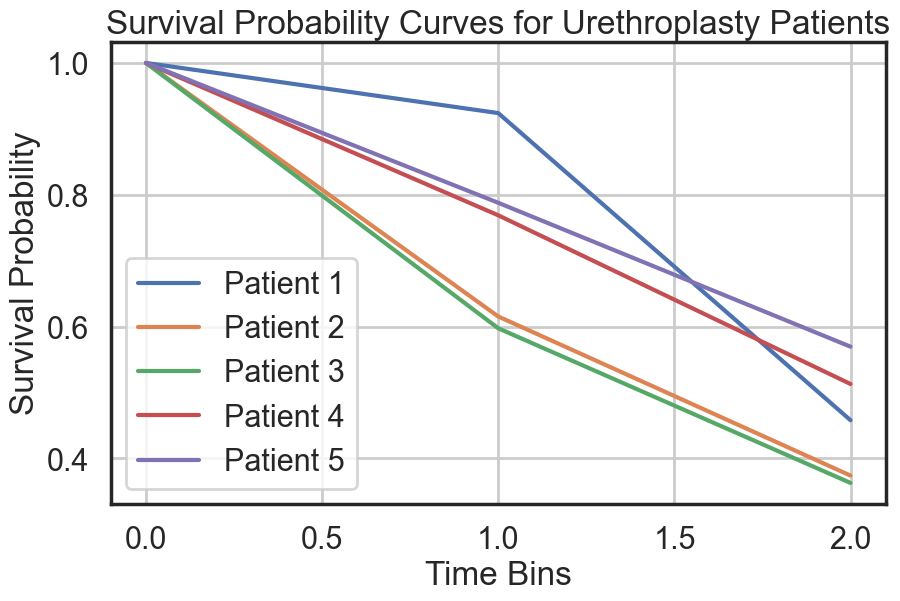

In [42]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the predicted survival probabilities from the CSV (assuming you've saved it as 'predicted_survival.csv')
df_pred_survival = pd.read_csv('/Users/preciousajilore/Documents/GitHub/torchmtlr/notebooks/predicted_survival.csv')

# Define the time bins (replace this with the actual time bins from your model)
time_bins = [0, 1, 2]  # Adjust based on your model's time intervals

# Plot survival curves for the first 5 patients (adjust the range if you want more/less)
plt.figure(figsize=(10, 6))
for i in range(5):  # Change the range to plot more or fewer patients
    plt.plot(time_bins, df_pred_survival.iloc[i], label=f'Patient {i+1}')

# Add labels and title
plt.xlabel('Time Bins')
plt.ylabel('Survival Probability')
plt.title('Survival Probability Curves for Urethroplasty Patients')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()


In [43]:


# Load the predicted risk values
df_pred_risk = pd.read_csv('/Users/preciousajilore/Documents/GitHub/torchmtlr/notebooks/predicted_risk.csv')

# Define thresholds for stratification (adjust these values based on your model's predictions)
df_pred_risk['Risk Category'] = pd.cut(df_pred_risk['Risk'], 
                                       bins=[0, 1, 2, float('inf')], 
                                       labels=['Low', 'Medium', 'High'])

print(df_pred_risk.head())




       Risk Risk Category
0  1.182067        Medium
1  1.895454        Medium
2  1.993993        Medium
3  1.100240        Medium
4  0.921865           Low


In [46]:
df_test = pd.DataFrame({
    'time': df_test_norm['time'],
    'event': df_test_norm['event'],
    'pred_risk': df_pred_risk['Risk']
})

print(df_test.head(20))

    time  event  pred_risk
0    6.0    0.0   1.182067
1    NaN    NaN   1.895454
2    NaN    NaN   1.993993
3    NaN    NaN   1.100240
4    3.8    0.0   0.921865
5    4.0    0.0   1.196779
6    NaN    NaN   0.994140
7    5.0    0.0   1.366015
8    NaN    NaN   3.804188
9    4.0    0.0   4.016673
10   4.0    0.0   2.701723
11   9.0    0.0   0.457165
12   1.0    0.0   1.207075
13   NaN    NaN   0.880434
14   NaN    NaN   1.784161
15  29.0    0.0   2.187942
16  28.0    0.0   1.601203
17   NaN    NaN   1.630961
18   6.0    0.0   1.771011
19   NaN    NaN   0.963701


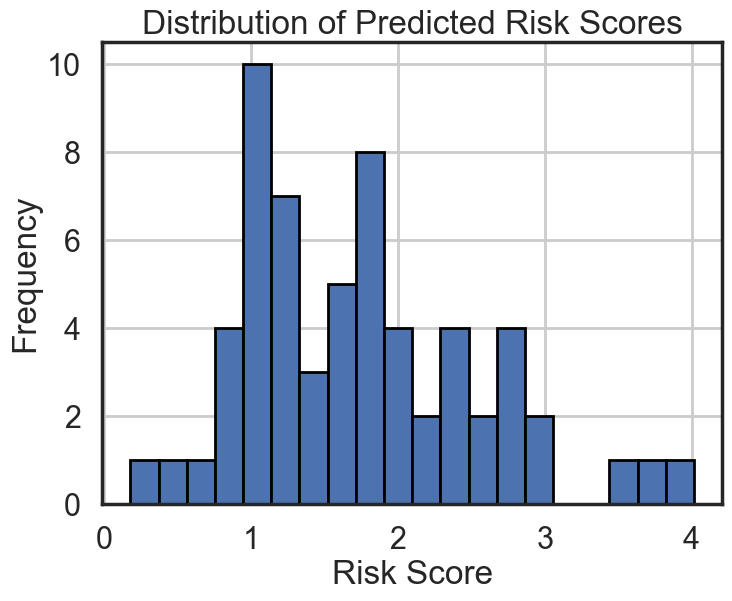

In [45]:
# Plot a histogram of predicted risks
plt.figure(figsize=(8, 6))
plt.hist(df_pred_risk['Risk'], bins=20, edgecolor='black')
plt.title('Distribution of Predicted Risk Scores')
plt.xlabel('Risk Score')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

## Experiments with simulated data

Let's first see how MTLR performs on a simulated dataset. We'll generate a dataset with 10 Gaussian features and linear, constant hazard. The hazard is given by:

$$
h(\mathbf{x}) = x_1 + 2x_2
$$

and the survival times are generated randomly from an exponential distribution:

$$
T \sim \mathrm{Exp}(\lambda_{\mathrm{base}}\exp(h(\mathbf{x})).
$$

Note that only 2 of the variables correlate with the survival time and the rest are noise. We also adjust the censoring time such that approximately 10% of the observations are censored.

In [9]:
def make_synthetic_data(n_samples=8000, n_noise_features=8, base_hazard=.1, percent_censor=.1):
    """Generates a synthetic survival dataset with linear hazard."""
    x = np.random.standard_normal((n_samples, n_noise_features + 2))
    hazards = x[:, 0] + 2 * x[:, 1]
    event_time = np.random.exponential(1 / (base_hazard * np.exp(hazards)))
    censor_time = np.quantile(event_time, 1 - percent_censor)

    time = np.minimum(event_time, censor_time)
    event = (event_time < censor_time).astype(int)

    return pd.DataFrame({
        "time": time,
        "event": event,
        **{f"x{i+1}": x[:, i] for i in range(x.shape[1])}
    })

In [10]:
data = make_synthetic_data()

In [37]:
# prepare data
data_train, data_test = train_test_split(data, test_size=.25, random_state=42)
time_bins = make_time_bins(data_train["time"].values, event=data_train["event"].values)
num_time_bins = len(time_bins)

# fit MTLR model 
mtlr = MTLR(in_features=10, num_time_bins=num_time_bins)
mtlr = train_mtlr(mtlr, data_train, time_bins, num_epochs=100, 
                  lr=.005, batch_size=512, verbose=True, device=device)

with torch.no_grad():
    pred = mtlr(torch.tensor(data_test.drop(["time", "event"], axis=1).values, dtype=torch.float, device=device))
    pred_survival = mtlr_survival(pred).cpu().numpy()
    pred_risk = mtlr_risk(pred).cpu().numpy()

[epoch  100/100]: 100%|██████████| 100/100 [00:12<00:00,  7.96it/s, loss = 3.7176]


We can check the model's [concordance index](https://stats.stackexchange.com/questions/29815/how-to-interpret-the-output-for-calculating-concordance-index-c-index) to make sure it has converged.

In [38]:
# Note that the CI function expects the predictions to be higher for
# longer survivors, which can be achieved by flipping the sign of the risk.
ci = concordance_index(data_test["time"], -pred_risk, event_observed=data_test["event"])
print(f"CI = {ci:.2f}")

CI = 0.84


Since the MTLR model associates a parameter with each time bin, we can plot the trained parameter values over time to see how the importance of each feature changes over time.

In [39]:
def plot_weights(weights, time_bins, feature_names):
    """Plot MTLR model parameters over time."""
    #print(type(weights))
    if isinstance(feature_names, pd.Index):
        feature_names = feature_names.tolist()

    top_idxs = torch.argsort(weights.abs().sum(1), descending=True)[:5]
    fig, ax = plt.subplots()
    for i in top_idxs:
        weights_i = weights[i].numpy()
        ax.plot(np.pad(time_bins, (1, 0))[:-1], weights_i, label=feature_names[i])
    ax.set_xlabel("Time (days)")
    ax.set_ylabel("Weight")
    ax.axhline(0, c="k", linestyle="--")
    fig.legend()
    return ax

In [40]:
feature_names = data.drop(["time", "event"], axis=1).columns
print(type(feature_names))

<class 'pandas.core.indexes.base.Index'>


In [38]:
#feature_names = data.drop(["time", "event"], axis=1).columns
plot_weights(mtlr.mtlr_weight.detach().cpu(), time_bins, feature_names)

NameError: name 'plot_weights' is not defined

From the plot, we can see that the model is able to correctly identify the 2 important variables ($x_1$ and $x_2$) while assigning low weights to the noise variables. Furthermore, the weights are more or less constant over time (reflecting the constant hazard) and the weight for $x_2$ is approximately twice the weight of $x_1$, as it should be. This gives us reasonable confidence that our MTLR implementation is correct!

## SUPPORT dataset
Now let's test the MTLR model on some real-world data. We'll use the SUPPORT2 dataset (available [here](https://biostat.app.vumc.org/wiki/Main/SupportDesc)), consisting of various physiological and demographic features of about 9000 patients admitted to the ICU and followed up for several months afterwards. The goal is to predict the time to death from any cause. About 30% of the survival times are censored.

We will compare it to the [Cox proportional hazards model](https://en.wikipedia.org/wiki/Proportional_hazards_model), which is a standard approach in survival analysis.

In [42]:
def make_support_data():
    """Downloads and preprocesses the SUPPORT dataset from [1]_.
    
    The missing values are filled using either the recommended
    standard values, the mean (for continuous variables) or the mode
    (for categorical variables).
    Refer to the dataset description at 
    https://biostat.app.vumc.org/wiki/Main/SupportDesc for more information.
    
    Returns
    -------
    pd.DataFrame
        DataFrame with processed covariates for one patient in each row.
        
    References
    ----------
    ..[1] W. A. Knaus et al., ‘The SUPPORT Prognostic Model: Objective Estimates of Survival 
    for Seriously Ill Hospitalized Adults’, Ann Intern Med, vol. 122, no. 3, p. 191, Feb. 1995.
    """
    url = "https://biostat.app.vumc.org/wiki/pub/Main/DataSets/support2csv.zip"
    
    # Remove other target columns and other model predictions
    cols_to_drop = [
        "hospdead",
        "slos",
        "charges",
        "totcst",
        "totmcst",
        "avtisst",
        "sfdm2",
        "adlp",
        "adls",
        "dzgroup",
        "sps",
        "aps",
        "surv2m",
        "surv6m",
        "prg2m",
        "prg6m",
        "dnr",
        "dnrday",
        "hday",
    ]

    # `death` is the overall survival event indicator
    # `d.time` is the time to death from any cause or censoring 
    data = (pd.read_csv(url)
            .drop(cols_to_drop, axis=1)
            .rename(columns={"d.time": "time", "death": "event"}))
    data["event"] = data["event"].astype(int)
    
    data["ca"] = (data["ca"] == "metastatic").astype(int)

    # use recommended default values from official dataset description ()
    # or mean (for continuous variables)/mode (for categorical variables) if not given
    fill_vals = {
        "alb":     3.5,
        "pafi":    333.3,
        "bili":    1.01,
        "crea":    1.01,
        "bun":     6.51,
        "wblc":    9,
        "urine":   2502,
        "edu":     data["edu"].mean(),
        "ph":      data["ph"].mean(),
        "glucose": data["glucose"].mean(),
        "scoma":   data["scoma"].mean(),
        "meanbp":  data["meanbp"].mean(),
        "hrt":     data["hrt"].mean(),
        "resp":    data["resp"].mean(),
        "temp":    data["temp"].mean(),
        "sod":     data["sod"].mean(),
        "income":  data["income"].mode()[0],
        "race":    data["race"].mode()[0],
    }
    data = data.fillna(fill_vals)
    
    # one-hot encode categorical variables
    onehot_cols = ["sex", "dzclass", "income", "race"]
    data = pd.get_dummies(data, columns=onehot_cols, drop_first=True)
    
    return data

In [43]:
data = make_support_data()
data_train, data_test = train_test_split(data, test_size=.3, random_state=32)

In [44]:
percent_censored = 1 - data["event"].mean()
round(percent_censored, 2)

0.32

In [45]:
len(data)

9105

We'll use 2 metrics to assess the performance of each model:
- [Area under the ROC curve](https://en.wikipedia.org/wiki/Receiver_operating_characteristic#Area_under_the_curve) at time $t$: measures binary classification performance (alive vs dead) at time $t$. Perfect model would achieve $AUC = 1$, while random guessing scores .5.
- [Brier score](https://en.wikipedia.org/wiki/Brier_score) (aka mean squared error) at time $t$: measures the accuracy and calibration of predicted survival probabilites at time $t$ (lower is better). A perfectly accurate and calibrated model would achieve $\mathrm{BS} = 0$, while a randomly-guessing model (always predicting $P(\mathrm{event}) = .5$) would achieve $\mathrm{BS} = .25$ (since $(1 - .5)^2 = (0 - .5)^2 = .25$).

Following the original publication, we will compute the metrics at 25%, 50% and 75% quantiles of event times.

In [46]:
def compute_metric_at_times(metric, time_true, prob_pred, event_observed, score_times):
    """Helper function to evaluate a metric at given timepoints."""
    scores = []
    for time, pred in zip(score_times, prob_pred.T):
        target = time_true > time
        uncensored = target | event_observed.astype(bool)
        scores.append(metric(target[uncensored], pred[uncensored]))
        
    return scores


def brier_score_at_times(time_true, prob_pred, event_observed, score_times):
    scores = compute_metric_at_times(brier_score_loss, 
                                     time_true,
                                     prob_pred,
                                     event_observed,
                                     score_times)
    return scores


def roc_auc_at_times(time_true, prob_pred, event_observed, score_times):
    scores = compute_metric_at_times(roc_auc_score, 
                                     time_true,
                                     prob_pred, 
                                     event_observed,
                                     score_times)
    return scores

In [47]:
# evaluate model performance at 25%, 50% and 75% of survival time distribution
eval_times = np.quantile(data.loc[data["event"] == 1, "time"], [.25, .5, .75]).astype(int)
metrics = []

data_train, mean_train, std_train = normalize(data_train, skip_cols=["time", "event"])
data_test, *_ = normalize(data_test, mean=mean_train, std=std_train, skip_cols=["time", "event"])
x_test = torch.tensor(data_test.drop(["time", "event"], axis=1).values, dtype=torch.float, device=device)
num_features = data_train.shape[1] - 2
time_bins = make_time_bins(data_train["time"].values, event=data_train["event"].values)
num_time_bins = len(time_bins)

# fit Cox model
cph = CoxPHFitter()
cph.fit(data_train, duration_col="time", event_col="event")

pred_survival = cph.predict_survival_function(data_test, eval_times).values.T

bs = brier_score_at_times(data_test["time"], pred_survival, data_test["event"], eval_times)
auc = roc_auc_at_times(data_test["time"], pred_survival, data_test["event"], eval_times)
metrics.append({
    "model": "cox",
    **{f"bs_{t}": bs[i] for i, t in enumerate(eval_times)},
    **{f"auc_{t}": auc[i] for i, t in enumerate(eval_times)}
})

# fit MTLR model 
mtlr = DeepMTLR(in_features=num_features, num_time_bins=num_time_bins)
mtlr = train_mtlr_cv(mtlr, data_train, time_bins, num_epochs=500, lr=.005,
                     cv=3, verbose=True, batch_size=512, device=device)

with torch.no_grad():
    pred = mtlr(x_test)
    pred_survival = mtlr_survival_at_times(pred, time_bins, eval_times)

bs = brier_score_at_times(data_test["time"], pred_survival, data_test["event"], eval_times)
auc = roc_auc_at_times(data_test["time"], pred_survival, data_test["event"], eval_times)
metrics.append({
    "model": "mtlr",
    **{f"bs_{t}": bs[i] for i, t in enumerate(eval_times)},
    **{f"auc_{t}": auc[i] for i, t in enumerate(eval_times)}
})

testing c1 =    1000.0: 100%|██████████| 3/3 [02:07<00:00, 42.43s/it, val nll = 7061.23]


training with c1 = 1.0


[epoch  500/500]: 100%|██████████| 500/500 [01:07<00:00,  7.38it/s, loss = 3.1493]


### Performance comparison with Cox model
Because it directly models the survival curve, MTLR is able to achieve better classification AUC than the Cox model (which estimates the survival curve in a post-hoc procedure). MTLR also achieves lower Brier score (especially at early timepoints), indicating better calibration.

In [48]:
pd.DataFrame(metrics).round(3)

,model,bs_14,bs_58,bs_252,auc_14,auc_58,auc_252
0,cox,0.134,0.196,0.208,0.718,0.715,0.738
1,mtlr,0.128,0.192,0.211,0.765,0.727,0.728


### Visualizing the predicted survival curves
Let's plot the predicted survival curves for both models for a few randomly chosen subjects. There are a few things to notice here:
- The Cox model generates curves with similar overall shape due to the proportional hazards assumption. Note that the curves for any two patients never cross (unless they have exactly the same features).
- In contrast, the MTLR curves are not constrained to a particular shape. This allows for greater flexibility while still keeping the predictions reasonably smooth.
- The $\ell_2$ regularization strength controls the smoothness of MTLR predicted curves. By default it's selected using cross validation, which should give fairly smooth curves. Try playing around with it and observe how the shape of the curves changes.

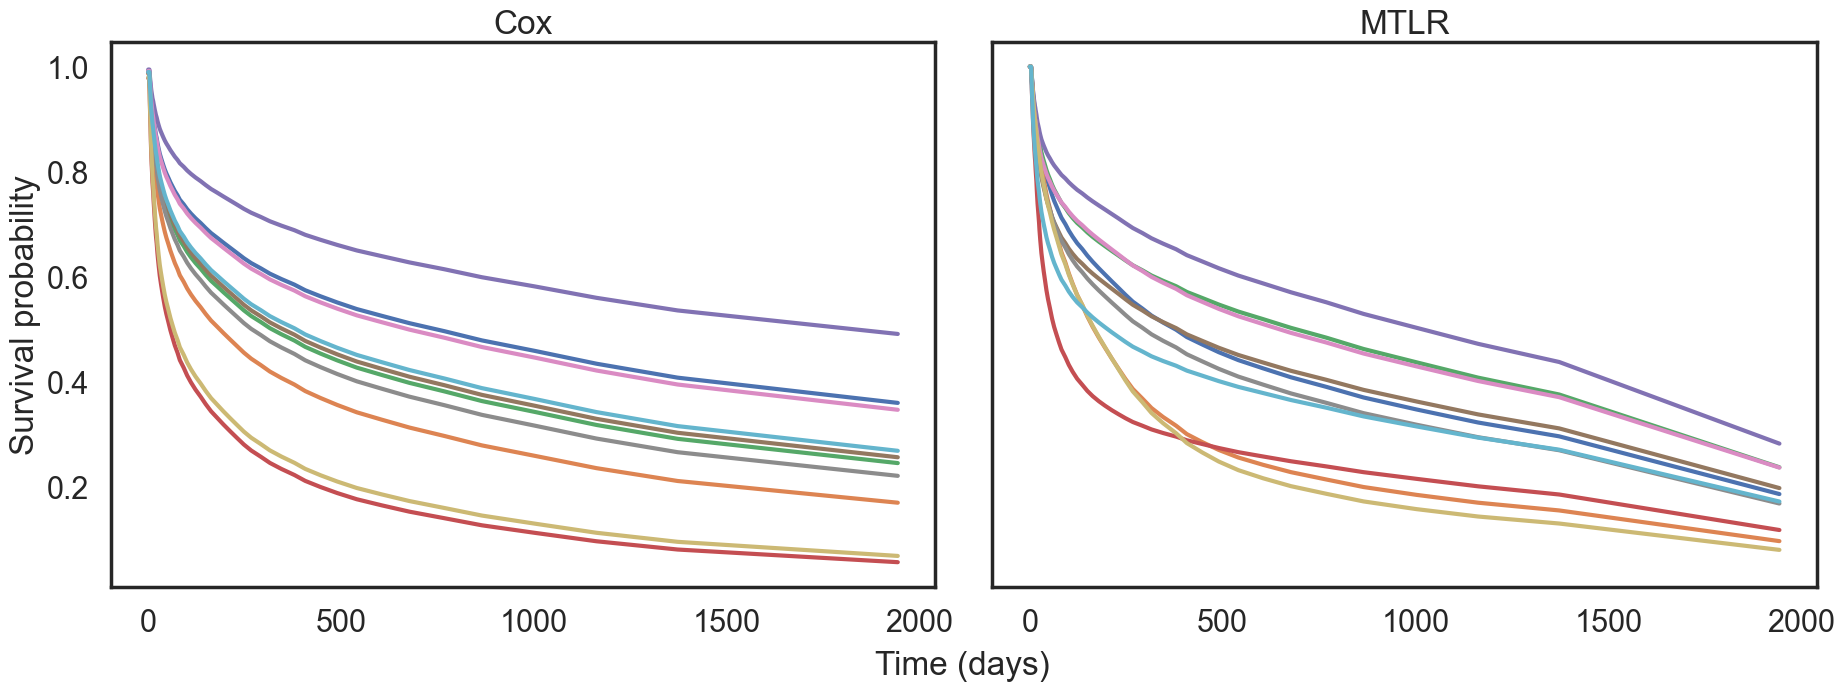

In [49]:
idxs = np.random.choice(np.arange(len(data_test)), 10)

fig, ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(19, 7))

pred_survival_cph = cph.predict_survival_function(data_test, np.pad(time_bins, (1, 0))).values.T
pred_survival_mtlr = mtlr_survival(pred).cpu()

for idx in idxs:
    ax[0].plot(np.pad(time_bins, (1, 0)), pred_survival_cph[idx])
    ax[1].plot(np.pad(time_bins, (1, 0)), pred_survival_mtlr[idx])

ax[0].set_ylabel("Survival probability")
ax[1].set_ylabel("")
ax[0].set_title("Cox")
ax[1].set_title("MTLR")
fig.text(0.52,0.01, "Time (days)", ha="center", va="center")
fig.tight_layout()

### Visualising model parameters
We can have a look at the model parameters to get an idea of the learned relationships between features and the risk of event over time. Here we select the 5 features with the highest sum of absolute weight values over time. Again, the $\ell_2$ regularization strength determines the smoothness of weights. Notice how the weights vary over time, unlike the Cox model (where the hazard ratio for each covariate is constant over time). Although it can be a useful diagnostic tool, you need to be careful not to over-interpret this plot as it can sometimes be misleading, e.g. some features are highly correlated.

In [50]:
feature_names = data.drop(["time", "event"], axis=1).columns
plot_weights(mtlr.mtlr_weight.detach().cpu(), time_bins, feature_names)

AttributeError: 'DeepMTLR' object has no attribute 'mtlr_weight'

## Deep MTLR
A cool aspect of MTLR is that it is differentiable end-to-end. This lets us increase the capacity of the model by using a neural net to learn nonlinear representations end-to-end with survival prediction. Simply stack a recognition network on top of the model and watch the autodiff magic happen!

In [51]:
# The MTLR module can be used just like any other PyTorch layer
mtlr = nn.Sequential(
    nn.Linear(num_features, 100),
    nn.ELU(),
    nn.Dropout(.4),
    nn.Linear(100, 32),
    nn.ELU(),
    nn.Dropout(.4),
    MTLR(in_features=32, num_time_bins=num_time_bins)
)

mtlr = train_mtlr_cv(mtlr, data_train, time_bins, num_epochs=500, lr=.005,
                     batch_size=512, cv=3, weight_decay=1e-5, verbose=True, device=device)

with torch.no_grad():
    pred = mtlr(torch.tensor(data_test.drop(["time", "event"], axis=1).values, dtype=torch.float))
    pred_survival = mtlr_survival_at_times(pred, time_bins, eval_times)

bs = brier_score_at_times(data_test["time"], pred_survival, data_test["event"], eval_times)
auc = roc_auc_at_times(data_test["time"], pred_survival, data_test["event"], eval_times)
metrics.append({
    "model": "deepmtlr",
    **{f"bs_{t}": bs[i] for i, t in enumerate(eval_times)},
    **{f"auc_{t}": auc[i] for i, t in enumerate(eval_times)}
})

testing c1 =    1000.0: 100%|██████████| 3/3 [02:27<00:00, 49.16s/it, val nll = 6827.25]


training with c1 = 0.1


[epoch  500/500]: 100%|██████████| 500/500 [01:19<00:00,  6.32it/s, loss = 3.1902]


In [52]:
pd.DataFrame(metrics).round(3)

,model,bs_14,bs_58,bs_252,auc_14,auc_58,auc_252
0,cox,0.134,0.196,0.208,0.718,0.715,0.738
1,mtlr,0.128,0.192,0.211,0.765,0.727,0.728
2,deepmtlr,0.126,0.191,0.211,0.788,0.748,0.735


Using a neural net, we're able to achieve better classification accuracy and calibration than the linear model. The gains could be even bigger if we had a larger dataset to learn from.

## Visualising learned representations
We can inspect the learned features in the penultimate layer (just before the MTLR head) to see if the model is able to learn meaningful representations. We'll use [UMAP](https://arxiv.org/abs/1802.03426) to embed the learned features in 2 dimensions for visualisation.

<>:12: SyntaxWarning: invalid escape sequence '\l'
<>:12: SyntaxWarning: invalid escape sequence '\l'
/var/folders/cl/h60hyp6s1jg6rr9n0nfgvphw0000gn/T/ipykernel_13410/908018975.py:12: SyntaxWarning: invalid escape sequence '\l'
  plt.colorbar(label="$\log(\mathrm{time})$")
/Users/preciousajilore/Documents/GitHub/torchmtlr/survivalenv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


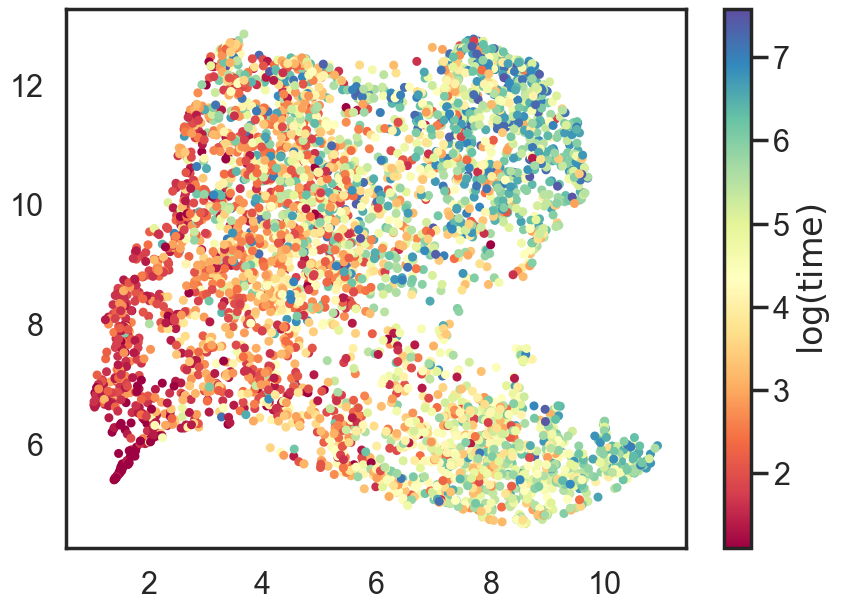

In [54]:
from umap import UMAP

uncensored = data_train.loc[data_train["event"] == 1]

with torch.no_grad():
    hidden = mtlr[:-1](torch.tensor(uncensored.drop(["time", "event"], axis=1).values, dtype=torch.float, device=device)).cpu().numpy()

umap = UMAP()
hidden_vis = umap.fit_transform(hidden)

plt.scatter(hidden_vis[:, 0], hidden_vis[:, 1], c=np.log(uncensored["time"]), s=20, cmap="Spectral")
plt.colorbar(label="$\log(\mathrm{time})$")

The samples seem to cluster by survival time in the embedding space, which seems to vary smoothly along the embedding dimensions. This means that the model is able to learn meaningful representations for survival prediction.

The potential of MTLR does not end here — since it's differentiable, it can be used like any other neural network layer, for example with an LSTM recognition network to handle time-varying features, or with a CNN stem to learn features directly from medical images (something I'm working on right now), or even something more exotic like a [neural ODE](https://papers.nips.cc/paper/8773-latent-ordinary-differential-equations-for-irregularly-sampled-time-series.pdf). 